In [282]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import  RobustScaler, FunctionTransformer,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, f_classif


import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## EDA - Exploratory Data Analysis

In [283]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [284]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

In [285]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

In [286]:
categorical_attributes = df.select_dtypes(include='object')
categorical_attributes.describe()

gender smoker     region
count    1338   1338       1338
unique      2      2          4
top      male     no  southeast
freq      676   1064        364

we will apply one hot encoder for attibutes `gender` and `region`

In [287]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no missing Values

<Axes: >

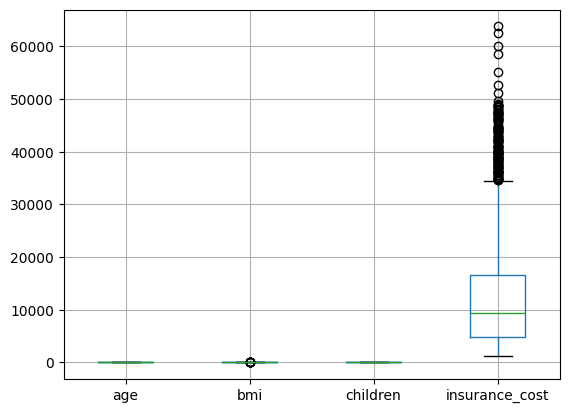

In [288]:
df.boxplot()

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'insurance_cost'}>]], dtype=object)

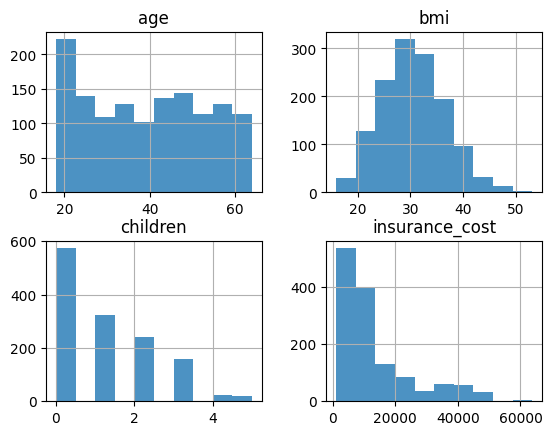

In [289]:
df.hist(bins=10, alpha=0.8)

## Data Preparation

First, Replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise

In [290]:
ins_cost_median=df['insurance_cost'].median()
df['insurance_cost_binary']= df['insurance_cost'].apply(lambda x: 1 if x > ins_cost_median else 0)

df = df.drop('insurance_cost', axis=1)
df['insurance_cost_binary'].value_counts()

insurance_cost_binary
0    669
1    669
Name: count, dtype: int64

Transform the  `smoker` column to binary.

In [291]:
mapper = {'yes': 1, 'no': 0}
df['smoker'] = df['smoker'].replace(mapper)
df['smoker'].value_counts()

smoker
0    1064
1     274
Name: count, dtype: int64

In [292]:
df.head()

age  gender     bmi  children  smoker     region  insurance_cost_binary
0   18    male  33.770         1       0  southeast                      0
1   18    male  34.100         0       0  southeast                      0
2   18  female  26.315         0       0  northeast                      0
3   18  female  38.665         2       0  northeast                      0
4   18  female  35.625         0       0  northeast                      0

Next we split the columns into a target *`y`* and predictors *`X`*.

In [293]:
y = df['insurance_cost_binary']
X = df.drop('insurance_cost_binary', axis=1)

#### Create Data processing pipleine

Apply one hot encoder for attibutes `gender` and `region`

Attributes `children` is skewed and have values 0 so will apply cube root transformation 

Attributes `age` is less skewed so will apply log transformation

Attribute `bmi` has outliers so will apply robut scalar

In [294]:
categorical_encoding = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("categorical_encoding",categorical_encoding, ['gender','region'] ),
        ("cubic_root_transform", FunctionTransformer(np.cbrt), ['children']),
        ("log_transform", FunctionTransformer(np.log),['age']), 
        ("robust_scaler", RobustScaler(), ['bmi']),    
        
    ],
    remainder="passthrough" # smoker
)

Now we can split the dataset into a training set and a test sets.

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

SVM

In [296]:
# create the main pipeline
pipe_svm = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('pca', PCA()),
    ('svm', svm.SVC(probability=True))
])

In [297]:
set_config(display="diagram")
pipe_svm

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_encoding',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'region']),
                                                 ('cubic_root_transform',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['children']),
                                                 ('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log'>),
                                                  ['age']),
                                                 ('robust_scaler',
                                                  RobustScaler(), ['bmi'])])),
                ('pca', PCA()), ('svm', SVC(probability=True))])

In [298]:
# prepare a parameter grid

param_grid_svm = {
  
    'pca__n_components': [2, 3, 4, 5],
    'svm__C': [0.1, 1, 10, 100, 1000],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    #'svm__kernel': ['rbf', 'linear', 'poly']}
    'svm__kernel': ['rbf', 'linear']}

search = GridSearchCV(pipe_svm, param_grid_svm, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.780:
Best parameters:  {'pca__n_components': 5, 'svm__C': 1000, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


Random Forest

In [299]:
# create the pipeline
pipe_rf = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('rfe', RFE(estimator=RandomForestClassifier())),
    ('rf', RandomForestClassifier())])

In [300]:
set_config(display="diagram")
pipe_rf

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_encoding',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'region']),
                                                 ('cubic_root_transform',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['children']),
                                                 ('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log'>),
                                                  ['age']),
                                                 ('robust_scaler',
                                                  RobustScaler(), ['bmi'])])),
                ('rfe', RFE(estimator=RandomForestClassifier())),
                ('rf', RandomForestClassifier())])

In [301]:
# prepare a parameter grid
param_grid_rf = {
    'rfe__n_features_to_select': [2, 3, 4, 5],
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe_rf, param_grid_rf, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.941:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 30, 'rfe__n_features_to_select': 5}


MLP CLassifier

In [302]:
# create the main pipeline
pipe_mlp = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('selectkbest', SelectKBest(score_func=f_classif)),
    ('mlp', MLPClassifier())
])

In [303]:
set_config(display="diagram")
pipe_mlp

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_encoding',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'region']),
                                                 ('cubic_root_transform',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['children']),
                                                 ('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log'>),
                                                  ['age']),
                                                 ('robust_scaler',
                                                  RobustScaler(), ['bmi'])])),
                ('selectkbest', SelectKBest()), ('mlp', MLPClassifier())])

In [304]:
# prepare a parameter grid

param_grid_mlp = {
    'selectkbest__k': [2, 3, 4, 5],
    'mlp__hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
}

search = GridSearchCV(pipe_mlp, param_grid_mlp, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

Best CV score = 0.921:
Best parameters:  {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 50, 25), 'selectkbest__k': 3}


## Compare Classification Models on Test Set

In [305]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [306]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [307]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

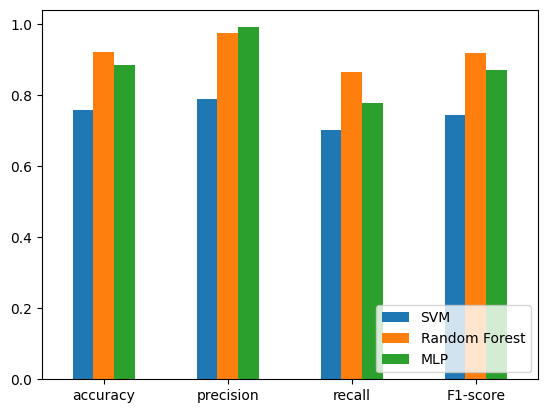

In [310]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'MLP': MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

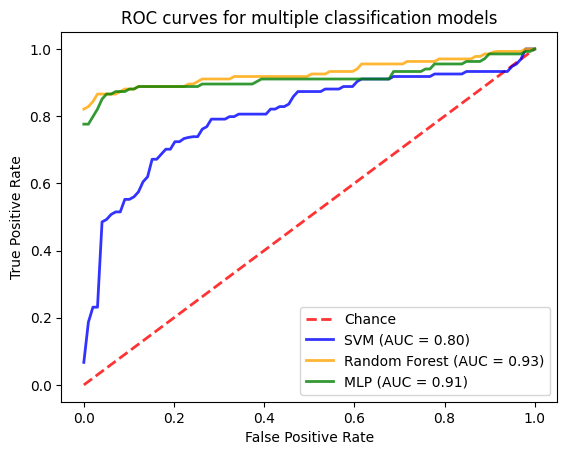

In [309]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='green', label='MLP (AUC = %0.2f)' % (MLP_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

## Train the Final Model